# Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: June 24, 2022
Pyleecan version:1.4.0
SciDataTool version:2.4.6


# How to solve optimization problem in Pyleecan

This tutorial explains how to use Pyleecan to solve **constrained global optimization** problem.

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Optimization.ipynb).  

The tutorial introduces the different objects to define each aspect of an optimization. To do so, we will present an example to maximize the average torque and minimize the first torque harmonic by varying the stator slot opening and the rotor external radius and by adding a constraint on torque ripple.

## Problem definition

The object [**OptiProblem**](https://www.pyleecan.org/pyleecan.Classes.OptiObjFunc.html) contains all the optimization problem characteristics:  

- the simulation/machine to iterate on
- the design variable to vary some parameters of the simulation (e.g. input current, topology of the machine)  
- the objective functions to minimize for the simulation  
- some constraints (optional)  

### Reference simulation definition

To define the problem, we first define a reference simulation. Each optimization evaluation will copy the reference simulation, set the value of the design variables and run the new simulation.

This exemple uses the simulation defined in the tutorial [How to define a simulation to call FEMM](https://www.pyleecan.org/tuto_Simulation_FEMM.html), (with less precision for FEMM mesh to speed up the calculations)

d:\github\pyleecan-public\pyleecan\Methods\Machine\Machine\plot.py:189: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


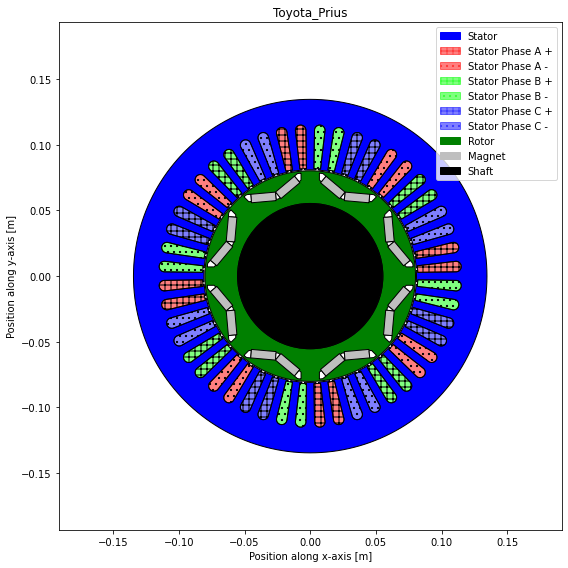

In [3]:
%matplotlib inline
from numpy import ones, pi, array, linspace
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.Output import Output
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

# Import the machine from a script
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
Toyota_Prius.plot()
rotor_speed = 2000 # [rpm] 

# Create the Simulation
simu_ref = Simu1(name="EM_SIPMSM_AL_001", machine=Toyota_Prius)   

# Defining Simulation Input
simu_ref.input = InputCurrent()

# time discretization [s]
simu_ref.input.Nt_tot = 16 

# Angular discretization along the airgap circonference for flux density calculation
simu_ref.input.Na_tot = 1024 

# Defining Operating Point
simu_ref.input.OP = OPdq()
simu_ref.input.OP.N0 = rotor_speed # Rotor speed as a function of time [rpm]
# Stator sinusoidal currents
simu_ref.input.OP.Id_ref = -100 # [Arms]
simu_ref.input.OP.Iq_ref = 200 # [Arms]

# Definition of the magnetic simulation (is_mmfr=False => no flux from the magnets)
simu_ref.mag = MagFEMM(
    type_BH_stator=0, # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    type_BH_rotor=0,  # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    file_name = "", # Name of the file to save the FEMM model
    is_periodicity_a=True, # Use Angular periodicity
    is_periodicity_t=True,  # Use time periodicity
    Kmesh_fineness = 0.2, # Decrease mesh precision
    Kgeo_fineness = 0.2, # Decrease mesh precision
)

# We only use the magnetic part 
simu_ref.force = None
simu_ref.struct = None 

### Minimization problem definition

To setup the optimization problem, we define some objective functions using the [**OptiObjective**](https://www.pyleecan.org/pyleecan.Classes.OptiObjective.html) object (which behave the same way as [**DataKeeper**](https://www.pyleecan.org/pyleecan.Classes.DataKeeper.html)). 

Each objective function is stored in the *keeper* attribute of a **OptiObjective**. keeper is a function and can be set either with a string (mandatory to be able to save the object) or directly with a function (the function will be discarded when saving). This type of function takes an output object in argument and returns a float to **minimize**. 

We gather the objective functions into a list:

In [4]:
from pyleecan.Classes.OptiObjective import OptiObjective
import numpy as np

def harm1(output):
    """Return the first torque harmonic """
    harm_list = output.mag.Tem.get_magnitude_along("freqs")["T_{em}"]
    
    # Return the first torque harmonic
    return harm_list[1] 

my_obj = [
    OptiObjective(
        name="Maximization of the average torque",
        symbol="Tem_av",
        unit="N.m",
        keeper="lambda output: -abs(output.mag.Tem_av)",  # keeper can be saved
    ),
    OptiObjective(
        name="Minimization of the first torque harmonic",
        symbol="Tem_h1",
        unit="N.m",
        keeper=harm1,  # keeper will be cleaned in save
    ),
]

The first objective minimize the "-abs(output.mag.Tem_av)" and so maximize the average torque and is set with a string. 

The second objective is set as a function. To set it as a string, this function can be defined inside a file and then keeper can be defined as "path/to/file" (example available at https://github.com/Eomys/pyleecan/blob/master/Tests/Validation/Multisimulation/test_multi_multi.py with the function "make_gif")

### Design variables
We use the object [**OptiDesignVar**](https://www.pyleecan.org/pyleecan.Classes.OptiDesignVar.html) to define the design variables. 


To define a design variable, we have to specify different attributes:  

- *name* to define the design variable name
- *symbol* to access to the variable / for plot (must be unique)
- *unit* to define the variable unit
- *type_var* to specify the variable "type":  
    - *interval* for continuous variables  
    - *set* for discrete variables  
- *space* to set the variable bound
- *setter* to access to the variable in the simu object. This attribute **must begin by "simu"**.  
- *get_value* function that takes the space in argument and returns a variable value (To initiate the first generation)

We store the design variables in a list. For this example, we define two design variables: 

1. Stator slot opening: can be any value between 0 and the slot width.   
2. Rotor external radius: can be one of the four value specified \[99.8%, 99.9%, 100%, 100.1%\] of the default rotor external radius     

In [5]:
from pyleecan.Classes.OptiDesignVar import OptiDesignVar
import random

# Design variables
my_design_var = [
    OptiDesignVar(
        name="Stator slot opening",
        symbol = "SW0",
        unit = "m",
        type_var="interval",
        space=[
            0 * simu_ref.machine.stator.slot.W2,
            simu_ref.machine.stator.slot.W2,
        ],
        get_value="lambda space: random.uniform(*space)", # To initiate randomly the first generation
        setter="simu.machine.stator.slot.W0", # Variable to edit
    ),
    OptiDesignVar(
        name= "Rotor ext radius",
        symbol = "Rext",
        unit = "m",
        type_var="set",
        space=[
            0.998 * simu_ref.machine.rotor.Rext,
            0.999 * simu_ref.machine.rotor.Rext,
            simu_ref.machine.rotor.Rext,
            1.001 * simu_ref.machine.rotor.Rext,
        ],
        get_value="lambda space: random.choice(space)",
        setter = "simu.machine.rotor.Rext"
    ),
]

Setter and get_value are also functions defined as string, which enable to set more complex function. For instance, setter could be used to multiply all the slot parameter by a scalling factor (example available at https://github.com/Eomys/pyleecan/blob/master/Tests/Validation/Multisimulation/test_slot_scale.py)

### Constraints

The class [**OptiConstraint**](https://www.pyleecan.org/pyleecan.Classes.OptiConstraint.html) enables to define some constraint. For each constraint, we have to define the following attributes:  

- name  
- type_const: type of constraint  
    - "=="  
    - "<="  
    - "<"  
    - ">="  
    - ">"  
- value: value to compare  
- get_variable: function which takes output in argument and returns the constraint value  

We also store the constraints into a list.

In [6]:
from pyleecan.Classes.OptiConstraint import OptiConstraint
my_constraint = [
    OptiConstraint(
        name = "const1",
        type_const = "<=",
        value = 700,
        get_variable = "lambda output: abs(output.mag.Tem_rip_pp)",
    )
]

### Evaluation function & Problem definition

Finally we can define our problem by gathering the simulation to run, the design variables, the objectives functions, the constraints and by setting an evalutaion function. For this example we keep the default one which calls the `simu.run` method. 
A custom evaluation function can also be defined as illustrated in the Bayesian optimization tutorial.

In [7]:
from pyleecan.Classes.OptiProblem import OptiProblem


# Problem creation
my_prob = OptiProblem(
    simu=simu_ref, 
    design_var=my_design_var, 
    obj_func=my_obj,
    constraint = my_constraint,
    eval_func = None # To keep the default evaluation function (simu.run)
)

## Solver

Pyleecan separes the problem and solver definition to be able to create different solver that uses the same objects. 

The class [**OptiGenAlgNsga2**](https://www.pyleecan.org/pyleecan.Classes.OptiGenAlgNsga2Deap.html) enables to solve our problem using [NSGA-II](https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf) genetical algorithm. The algorithm takes several parameters:  

|Parameter|Description|Type|Default Value|  
| :-: | :- | :-: | :-: |  
|*problem*|Problem to solve|**OptiProblem**|mandatory|
|*size\_pop*| Population size per generation|**int**|40|  
|*nb\_gen*|Generation number|**int**|100|  
|*p\_cross*|Crossover probability|**float**|0.9|  
|*p\_mutate*|Mutation probability|**float**|0.1|  

  
The `solve` method performs the optimization and returns an [**OutputMultiOpti**](https://www.pyleecan.org/pyleecan.Classes.OutputMultiOpti.html) object which contains the results.

In [8]:
from pyleecan.Classes.OptiGenAlgNsga2Deap import OptiGenAlgNsga2Deap

# Solve problem with NSGA-II
solver = OptiGenAlgNsga2Deap(problem=my_prob, size_pop=16, nb_gen=8, p_mutate=0.5)
res = solver.solve()

17:14:20 Starting optimization...
	Number of generations: 8
	Population size: 16

17:14:20  gen     0: simu 1/16 ( 0.00%),    0 errors.
Design Variables: SW0: 6.92e-03, Rext: 8.03e-02
[17:14:20] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:14:20] Starting Magnetic module
[17:14:21] Computing Airgap Flux in FEMM
[17:14:24] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.81e+02, Tem_h1: 1.59e+01

17:14:24  gen     0: simu 2/16 ( 6.25%),    0 errors.
Design Variables: SW0: 5.53e-03, Rext: 8.01e-02
[17:14:24] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:14:24] Starting Magnetic module
[17:14:25] Computing Airgap Flux in FEMM
[17:14:28] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.74e+02, Tem_h1: 1.40e+01

17:14:28  gen     0: simu 3/16 (12.50%),    0 errors.
Design Variables: SW0: 2.55e-03, Rext: 8.03e-02
[17:14:28] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:14:28] Starting Magnetic mo

Objectives: Tem_av: -3.79e+02, Tem_h1: 1.53e+01

17:15:50  gen     1: simu 8/16 (43.75%),    0 errors.
Design Variables: SW0: 6.52e-03, Rext: 8.01e-02
[17:15:50] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:15:50] Starting Magnetic module
[17:15:51] Computing Airgap Flux in FEMM
[17:15:54] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.68e+02, Tem_h1: 1.20e+01

17:15:54  gen     1: simu 9/16 (50.00%),    0 errors.
Design Variables: SW0: 1.93e-03, Rext: 8.01e-02
[17:15:54] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:15:54] Starting Magnetic module
[17:15:55] Computing Airgap Flux in FEMM
[17:15:58] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.72e+02, Tem_h1: 1.48e+01

17:15:58  gen     1: simu 10/16 (56.25%),    0 errors.
Design Variables: SW0: 1.34e-03, Rext: 8.00e-02
[17:15:58] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:15:58] Starting Magnetic module
[17:15:59] Computing Airgap

[17:17:12] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.67e+02, Tem_h1: 1.60e+01

17:17:12  gen     3: simu 2/16 ( 6.25%),    0 errors.
Design Variables: SW0: 1.88e-03, Rext: 8.03e-02
[17:17:12] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:17:12] Starting Magnetic module
[17:17:13] Computing Airgap Flux in FEMM
[17:17:16] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.86e+02, Tem_h1: 1.80e+01

17:17:16  gen     3: simu 3/16 (12.50%),    0 errors.
Design Variables: SW0: 6.52e-03, Rext: 8.02e-02
[17:17:16] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:17:16] Starting Magnetic module
[17:17:17] Computing Airgap Flux in FEMM
[17:17:19] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.75e+02, Tem_h1: 1.49e+01

17:17:19  gen     3: simu 4/16 (18.75%),    0 errors.
Design Variables: SW0: 5.66e-03, Rext: 8.00e-02
[17:17:19] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:17:19] Startin

Objectives: Tem_av: -3.93e+02, Tem_h1: 1.60e+01

17:18:44  gen     4: simu 10/16 (56.25%),    0 errors.
Design Variables: SW0: 2.78e-03, Rext: 8.02e-02
[17:18:44] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:18:44] Starting Magnetic module
[17:18:45] Computing Airgap Flux in FEMM
[17:18:47] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.82e+02, Tem_h1: 1.76e+01

17:18:47  gen     4: simu 11/16 (62.50%),    0 errors.
Design Variables: SW0: 4.27e-03, Rext: 8.01e-02
[17:18:47] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:18:47] Starting Magnetic module
[17:18:48] Computing Airgap Flux in FEMM
[17:18:50] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.79e+02, Tem_h1: 1.44e+01

17:18:50  gen     4: simu 12/16 (68.75%),    0 errors.
Design Variables: SW0: 5.84e-03, Rext: 8.01e-02
[17:18:50] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:18:50] Starting Magnetic module
[17:18:51] Computing Airg

Objectives: Tem_av: -3.73e+02, Tem_h1: 1.49e+01

17:20:08  gen     5: Finished,    0 errors,   0 infeasible.

17:20:09  gen     6: simu 1/16 ( 0.00%),    0 errors.
Design Variables: SW0: 6.44e-03, Rext: 8.02e-02
[17:20:09] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:20:09] Starting Magnetic module
[17:20:10] Computing Airgap Flux in FEMM
[17:20:13] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.75e+02, Tem_h1: 1.51e+01

17:20:13  gen     6: simu 2/16 ( 6.25%),    0 errors.
Design Variables: SW0: 5.52e-03, Rext: 8.03e-02
[17:20:13] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:20:13] Starting Magnetic module
[17:20:15] Computing Airgap Flux in FEMM
[17:20:17] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.91e+02, Tem_h1: 1.65e+01

17:20:17  gen     6: simu 3/16 (12.50%),    0 errors.
Design Variables: SW0: 7.41e-03, Rext: 8.03e-02
[17:20:17] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17

[17:21:38] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.68e+02, Tem_h1: 1.00e+01

17:21:38  gen     7: simu 8/16 (43.75%),    0 errors.
Design Variables: SW0: 6.52e-03, Rext: 8.02e-02
[17:21:38] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:21:38] Starting Magnetic module
[17:21:39] Computing Airgap Flux in FEMM
[17:21:41] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.75e+02, Tem_h1: 1.49e+01

17:21:41  gen     7: simu 9/16 (50.00%),    0 errors.
Design Variables: SW0: 7.91e-03, Rext: 8.00e-02
[17:21:41] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:21:41] Starting Magnetic module
[17:21:42] Computing Airgap Flux in FEMM
[17:21:44] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.59e+02, Tem_h1: 1.18e+01

17:21:44  gen     7: simu 10/16 (56.25%),    0 errors.
Design Variables: SW0: 6.52e-03, Rext: 8.01e-02
[17:21:44] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[17:21:44] Starti

During the algorithm the object displays some data containing:

- number of errors: failure during the objective function execution
- number of infeasible: number of individual with constraints violations

## Plot results

**OutputMultiOpti** has several methods to display some results:  

- `plot_generation`: to plot individuals for in 2D  
- `plot_pareto`: to plot the pareto front in 2D    

<IPython.core.display.Javascript object>


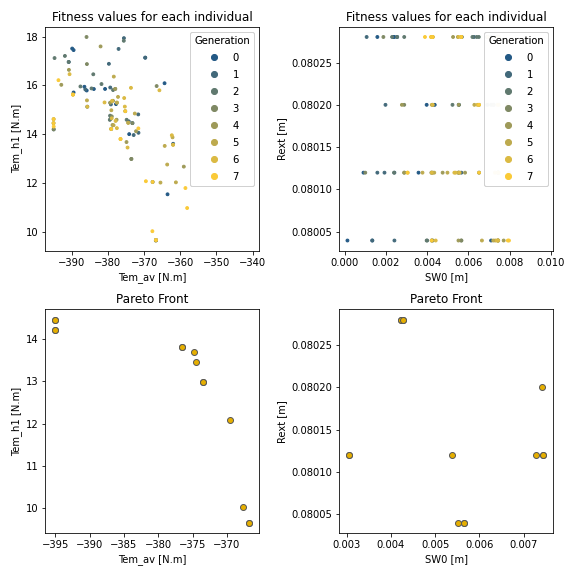

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [11]:
import matplotlib.pyplot as plt 

# Create a figure containing 4 subfigures (axes) 
fig, axs = plt.subplots(2,2, figsize=(8,8))

# Plot every individual in the fitness space 
res.plot_generation(
    x_symbol = "Tem_av", # symbol of the first objective function or design variable
    y_symbol = "Tem_h1", # symbol of the second objective function or design variable
    ax = axs[0,0] # ax to plot
)

# Plot every individual in the design space 
res.plot_generation(
    x_symbol = "SW0", 
    y_symbol = "Rext", 
    ax = axs[0,1]
)

# Plot pareto front in fitness space 
res.plot_pareto(
    x_symbol = "Tem_av", 
    y_symbol = "Tem_h1", 
    ax = axs[1,0]
)

# Plot pareto front in design space 
res.plot_pareto(
    x_symbol = "SW0", 
    y_symbol = "Rext", 
    ax = axs[1,1]
)

fig.tight_layout()
